# Manuel Romero García
## Máster en Big Data y Data Science UCM
### Tarea Text Mining

### 0. Importación

In [52]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i, encoding='utf-8') as f:
        output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

In [83]:
df = get_profner_data('C:\\Users\\mromg\\Documents\\profner\\')
df

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train
...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid


### 1. Limpieza y exploración de datos

In [99]:
import nltk
from nltk.corpus import stopwords
import re 
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from unidecode import unidecode

# Create an instance of the SnowballStemmer class for Spanish
stemmer = SnowballStemmer('spanish')
# limpieza personalizada (muchos errores pero creo que mejor que tokenizer)

stop_words = list(stopwords.words('spanish'))

def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    # eliminación de emojis
    emoji_pattern = re.compile("["
    u"\U0001F300-\U0001F6FF"  # symbols & pictographs
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u'\u2600-\u26FF\u2700-\u27BF'
    u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
    u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
    u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
    u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
    u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
    u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
    ']+', flags=re.UNICODE)
        
    nuevo_texto = re.sub(emoji_pattern,r' ',texto)
    # Se convierte todo el texto a minúsculas
    nuevo_texto = nuevo_texto.lower()
    # se eliminan acentos
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    #Eliminación todos los caracteres no alfanuméricos:
    nuevo_texto = re.sub(r'[^a-zA-Z0-9\s]', '', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminamos stopwords en español
    nuevo_texto = [token for token in nuevo_texto if token not in stop_words]
    # Eliminación de tokens con una longitud < 3
    nuevo_texto = [token for token in nuevo_texto if len(token) > 2]
    # stemm en español
    nuevo_texto = [stemmer.stem(token) for token in nuevo_texto]
    return(nuevo_texto)

df['tweet_text_clean'] = df['tweet_text'].apply(lambda x: limpiar_tokenizar(x))
df[['tweet_text','tweet_text_clean']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mromg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet_text,tweet_text_clean
0,CHINA: libera una pandemia EE.UU: libera OVNIS...,"[chin, liber, pandemi, eeuu, liber, ovnis, arg..."
1,San Francisco (EEUU) hace 100 años tras vivir ...,"[san, francisc, eeuu, hac, 100, anos, tras, vi..."
2,Porfi poneos la mascarilla o tendremos 28 nuev...,"[porfi, pone, mascarill, nuev, cancion, artist..."
3,El nuevo „covid normas y reglas recibimiento“ ...,"[nuev, cov, norm, regl, recib, comerci, minor,..."
4,Si el confinamiento ha dejado algo tocada tu e...,"[confin, dej, toc, estabil, mental, siempr, pu..."


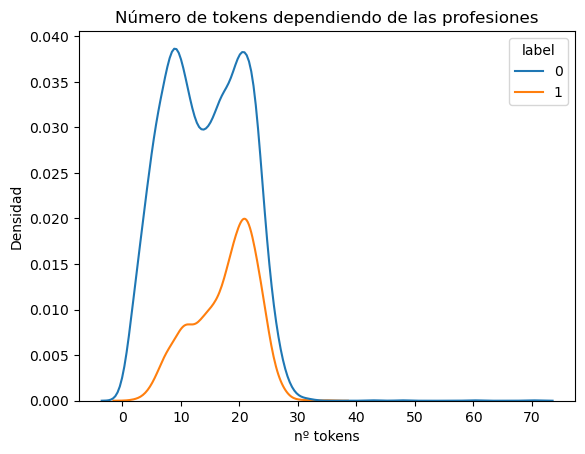

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
df['number_tokens'] = df['tweet_text_clean'].apply(len)

# Plot distribution of list lengths with density plot
sns.kdeplot(x=df['number_tokens'], hue=df['label'])
plt.title("Número de tokens dependiendo de las profesiones")
plt.xlabel("nº tokens")
plt.ylabel("Densidad")

# Show the plot
plt.show()

#### Parece que los tweets que mencionan profesiones son mucho menores que los que no las menciones, así que el modelo tendrá que ser rebalanceado. Por otra parte parece que la distribución de los tweets que no mencionan profesiones es bimodal

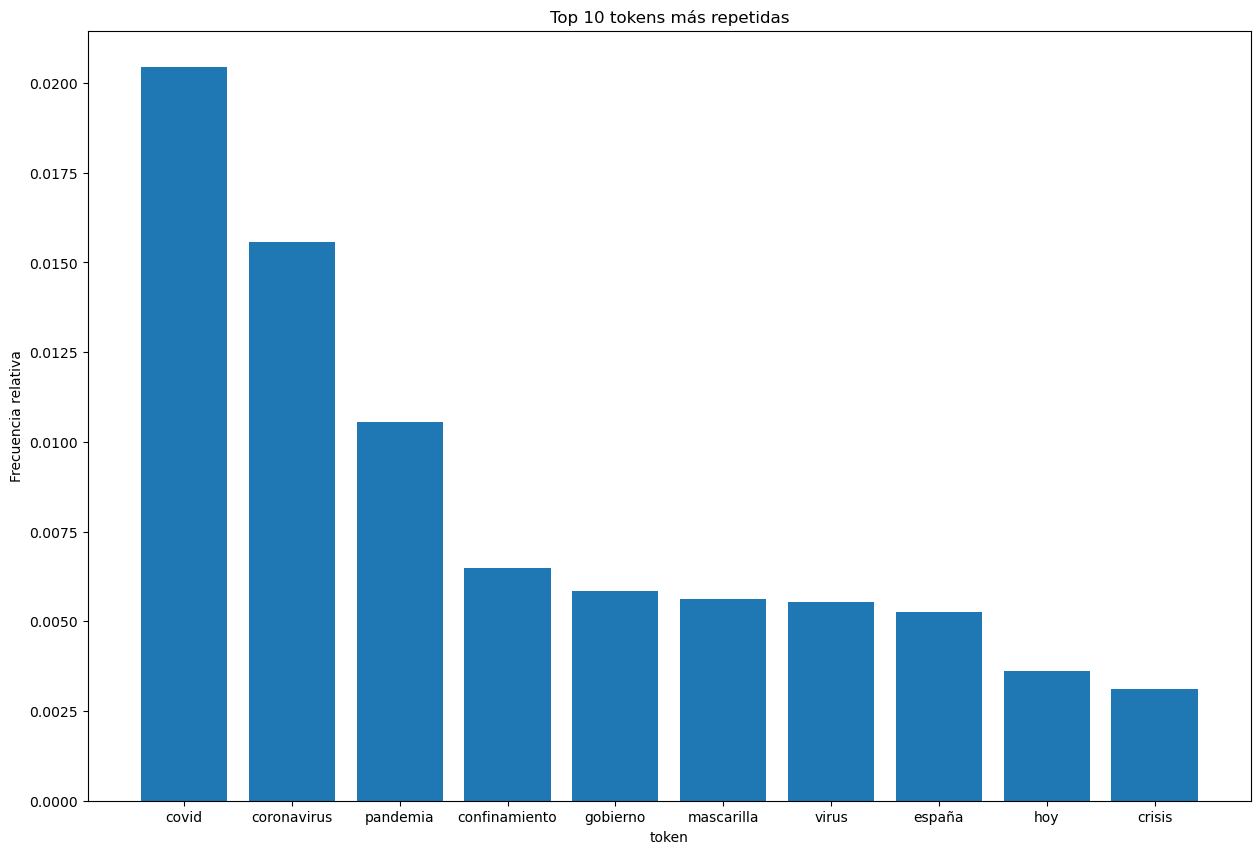

In [90]:
element_counts = {}
total_elements = 0
for row in df['tweet_text_clean']:
    for element in row:
        total_elements += 1
        if element not in element_counts:
            element_counts[element] = 1
        else:
            element_counts[element] += 1

# Sort the dictionary by frequency in descending order
sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)

# Create a bar plot of the top ten elements by frequency
top_elements = dict(sorted_counts[:10])
relative_frequencies = [count/total_elements for count in top_elements.values()]
plt.figure(figsize=(15, 10))
plt.bar(top_elements.keys(), relative_frequencies)
plt.title('Top 10 tokens más repetidas')
plt.xlabel('token')
plt.ylabel('Frecuencia relativa')
plt.show()

### 2. Vectorización